This notebook walks through a typical example of my approach to a new modeling problem or situation where someone is asking for a predictive model. A report of this style I like to keep on hand for my/my colleagues' reference or to share with technical team members for another team. For a presentation to a more general audience, the report would be very different, but still share the same message but with emphasis on how the findings and interpretations are relevant to the audience.


# Data Loading, Preparation, and EDA

In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
# Package options
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
pd.set_option('display.max_rows', 100)

In [3]:
SEED = 3141
N_SEEDS = 5
np.random.seed(SEED)
SEEDS = np.random.randint(0,1e4,N_SEEDS)
SEEDS

array([3432, 2393, 6218, 2555, 1353])

In [4]:
data = pd.read_csv('https://maca-screener.s3.us-east-2.amazonaws.com/churn-dataset.csv')
print(data.shape)
data.head(5)

(25812, 39)


,organization_id,organization_created_at,first_run_at,first_used_feature_a,first_used_feature_b,subscription_created_at,initial_mrr,num_passes_week_1,num_passes_week_2,num_passes_week_3,...,sum_test_duration_week_7,sum_test_duration_week_8,num_members_added_week_1,num_members_added_week_2,num_members_added_week_3,num_members_added_week_4,num_members_added_week_5,num_members_added_week_6,num_members_added_week_7,num_members_added_week_8
0,123028,2020-01-04 13:04:57.365000,2020-01-04 15:25:34.853000,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,1,0,0,0,0,0,0,0
1,123474,2020-01-07 18:59:36.265000,2020-01-07 19:02:53.788000,NaN,NaN,NaN,NaN,234.0,NaN,NaN,...,NaN,NaN,1,0,0,0,0,0,0,0
2,123816,2020-01-11 19:21:02.817000,2020-01-14 23:25:14.212000,NaN,NaN,2020-01-11 19:24:05.000000,99.0,373.0,38.0,NaN,...,NaN,NaN,1,0,0,0,0,0,0,0
3,124232,2020-01-14 12:57:14.305000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,0,0,0,0,0,0,0
4,125050,2020-01-21 20:47:22.752000,2020-01-21 21:01:23.842000,2020-01-26 14:43:17.299000,NaN,NaN,NaN,291.0,1047.0,766.0,...,19129.0,5319.0,3,0,0,0,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25812 entries, 0 to 25811
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   organization_id           25812 non-null  int64  
 1   organization_created_at   25812 non-null  object 
 2   first_run_at              10405 non-null  object 
 3   first_used_feature_a      3292 non-null   object 
 4   first_used_feature_b      1079 non-null   object 
 5   subscription_created_at   614 non-null    object 
 6   initial_mrr               614 non-null    float64
 7   num_passes_week_1         10405 non-null  float64
 8   num_passes_week_2         2473 non-null   float64
 9   num_passes_week_3         2001 non-null   float64
 10  num_passes_week_4         1734 non-null   float64
 11  num_passes_week_5         1601 non-null   float64
 12  num_passes_week_6         1401 non-null   float64
 13  num_passes_week_7         1354 non-null   float64
 14  num_pa

In [6]:
date_cols = ['organization_created_at',
             'first_run_at',
             'first_used_feature_a',
             'first_used_feature_b',
             'subscription_created_at'
            ]

for col in date_cols:
    data[col] = pd.to_datetime(data[col]).dt.date

In [7]:
# We check for potentially invalid entries and remove them
print("Rows with sub date before creation date:",len(data[data['subscription_created_at']<data['organization_created_at']]))
print("Rows with sub date on or after creation date:", len(data[~(data['subscription_created_at']<data['organization_created_at'])]))
data = data[~(data['subscription_created_at']<data['organization_created_at'])].reset_index(drop=True)

Rows with sub date before creation date: 1
Rows with sub date on or after creation date: 25811


In [8]:
# Drop columns from beyond 6 weeks
data = data.drop(columns=[c for c in data.columns if ('7' in c) or ('8' in c)])

In [9]:
sub_dt_min = data[~data['subscription_created_at'].isna()]['subscription_created_at'].min(skipna=True)
sub_dt_max = data[~data['subscription_created_at'].isna()]['subscription_created_at'].max(skipna=True)

sub_dt_min, sub_dt_max

(datetime.date(2020, 1, 5), datetime.date(2020, 8, 2))

In [10]:
# We drop rows where the customer subscribed after 6 weeks
data = data[~((data['subscription_created_at']-data['organization_created_at']).dt.days >= 42) |
            (data['subscription_created_at'].isna())
           ]
data.shape

(25670, 31)

In [11]:
# We create a binary variable for subscription status and if they subscribed within 6 weeks of first using
data['sub_in_6_weeks'] = ((data['first_run_at']-data['subscription_created_at']).fillna(pd.Timedelta(1e5, unit='D')).dt.days.astype(int) < 6*7)*1
data['sub_in_6_weeks'].mean(), data['sub_in_6_weeks'].sum()


(0.017374366965329176, 446)

The dataset is heavily imbalanced in favor of users not subscribing. Seeing the degree of the imbalance, we will try a combined under- and over- sampling technique called SMOTE-ENN (Synthetic Minority Over-sampling TEchnique with Edited Nearest Neighbors).

All models will be trained using 5-fold, stratified cross-validation. The dataset will be split 90/10 and stratified.

## Feature Engineering

We will manually create a series of columns using the following approach:
1. col {2,3,4} - organization_created_at (1) [days]
2. col {3,4} - first_run_at (2) [days]
3. first_used_feature_b - first_used_feature_a (3) [days]

In [12]:
data['id'] = data.index

for i, col in enumerate(date_cols[:-1], start=1):
    if i >= 2:
        data[f"{col}_minus_{date_cols[0]}"] = (data[col] - data[date_cols[0]]).dt.days
    if i >= 3:
        data[f"{col}_minus_{date_cols[1]}"] = (data[col] - data[date_cols[1]]).dt.days
    if i >= 4:
        data[f"{col}_minus_{date_cols[2]}"] = (data[col] - data[date_cols[2]]).dt.days

## EDA

In [13]:
sum_stats = data.describe().drop(columns=['organization_id', 'id']).transpose()
sum_stats

,count,mean,std,min,25%,50%,75%,max
initial_mrr,472.0,103.126589,65.193010,66.0,75.00,75.0,99.00,499.0
num_passes_week_1,10265.0,269.130151,2488.445391,0.0,7.00,44.0,122.00,121030.0
num_passes_week_2,2383.0,707.472514,3764.690141,0.0,13.00,63.0,251.50,105467.0
num_passes_week_3,1909.0,898.063908,4199.839170,0.0,18.00,79.0,356.00,91506.0
num_passes_week_4,1646.0,966.036452,3875.194980,0.0,21.00,102.5,432.00,71380.0
num_passes_week_5,1508.0,1056.591512,4669.305000,0.0,22.00,102.0,465.75,112810.0
num_passes_week_6,1307.0,1198.800306,4879.997345,0.0,28.00,114.0,561.00,93837.0
num_failures_week_1,10265.0,29.320896,385.208117,0.0,0.00,2.0,11.00,27332.0
num_failures_week_2,2383.0,46.411666,232.989143,0.0,1.00,6.0,26.00,8844.0
num_failures_week_3,1909.0,49.020430,166.934009,0.0,1.00,8.0,33.00,3584.0


There seems to be a few very large values for several of the variables. We will use UMAP to check for outliers in the global topology of the dataset.
<br><br>
For the NaN values, we will assume those mean there were no values run for that week for some reason (organization stopped using the tool, etc.) We remove all non-numeric columns, the dependent variables, and other information
that would skew the results (such as the initial Monthly Recurring Revenue from a subscription which is basically a proxy for subscription status).

In [14]:
X = data[list(sum_stats.index)].drop(columns=['sub_in_6_weeks', 'initial_mrr'])
y = data['sub_in_6_weeks'].values

/home/dalton/projects/screeners/maca-dash/env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dalton/projects/screeners/maca-dash/env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dalton/projects/screeners/maca-dash/env/li

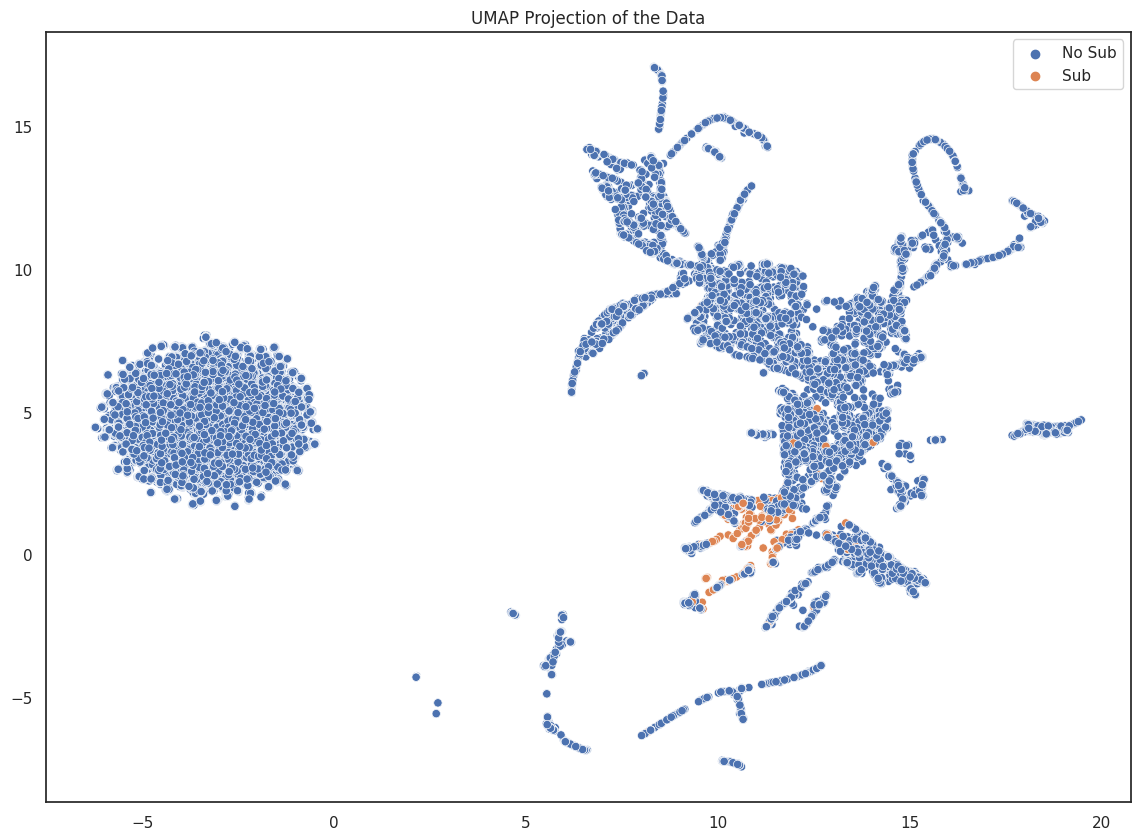

In [15]:
from sklearn.preprocessing import StandardScaler
import umap

scaled = StandardScaler().fit_transform(X.fillna(0))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    reducer = umap.UMAP(random_state=SEED)  # UMAP is rather sensitive to the random seed, so we fix this
    embedding = reducer.fit_transform(scaled)

sns.scatterplot(x=embedding[:,0], y=embedding[:,1], 
                hue=['No Sub' if x == 0 else 'Sub' for x in y])
plt.title('UMAP Projection of the Data')
plt.legend()
plt.show()

Interestingly, we see a fairly large cluster of points all of non-subscribers. Out of curiosity, we will remove them and generate a new embedding of the data to see if we might get a better global topology to work with for the remainder of the data. This will have the added advantage of helping alleviate some of the severity of the class imbalance. First, though, we will check if there are any subscribers in the cluster.

In [16]:
keep_idx = np.where(embedding[:,0]>0)[0]
len(keep_idx), abs(len(keep_idx)-len(data)), 1-(len(keep_idx)/len(data))

(10263, 15407, 0.6001947798987144)

In [17]:
y[np.where(embedding[:,0]<0)[0]].sum()

0

Over 60% of the observations fall in the large cluster, disjoint cluster. This will likely have a substantial impact on the global topology of the reduced dataset. None of the observations in that cluster are subscribers.

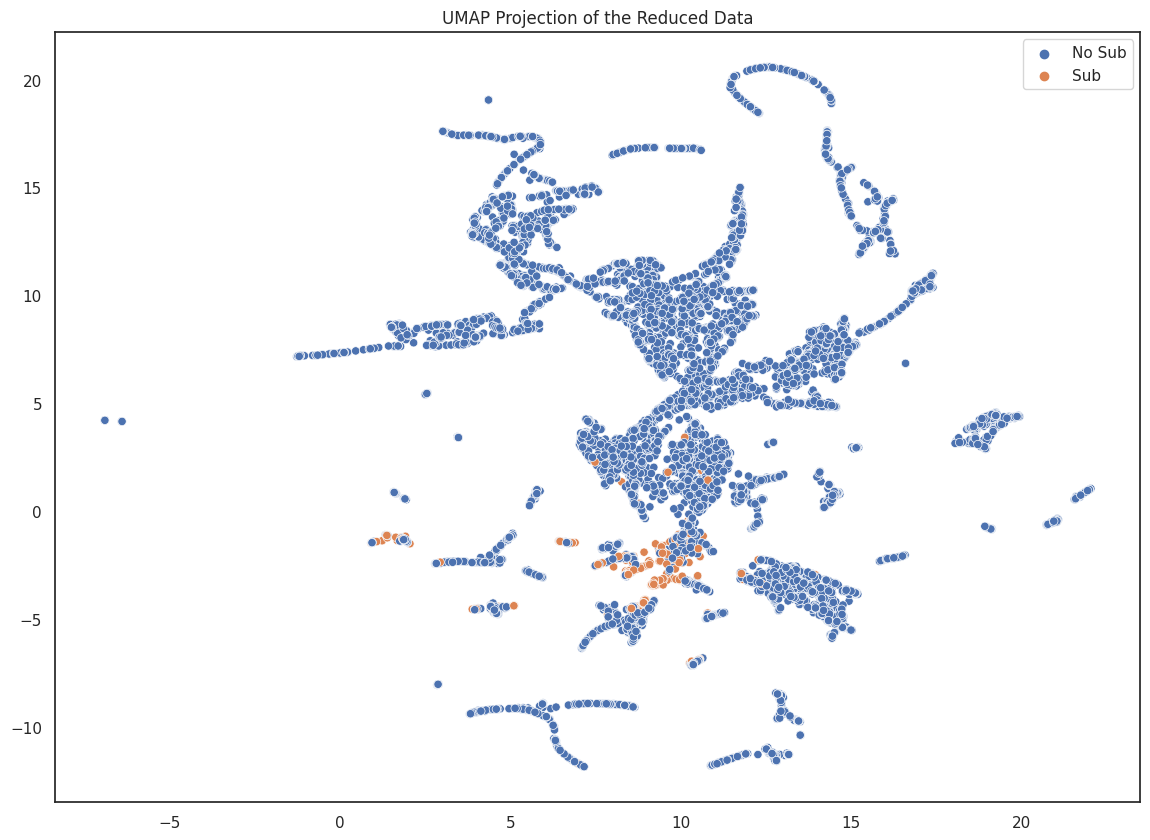

In [18]:
reducer_rdx = umap.UMAP(random_state=SEED)  # UMAP is rather sensitive to the random seed, so we fix this
embedding_rdx = reducer_rdx.fit_transform(scaled[keep_idx])

sns.scatterplot(x=embedding_rdx[:,0], y=embedding_rdx[:,1],
                hue=['No Sub' if x == 0 else 'Sub' for x in y[keep_idx]])
plt.title('UMAP Projection of the Reduced Data')
plt.legend()
plt.show()

The distribution of the subscribers is somewhat localized when looking at the UMAP reduction. We will remove the cluster from the dataset since this will both 1) reduce the degree of the imbalance and 2) give us an additional set of data to validate the model as we would expect that all of those points are assigned a low probability of eventually subscribing.
<br><br>
*Aside: It would be interesting to analyze the cluster we removed to see what characteristics it has. Additionally, a model to separate between that cluster and this might also be an interesting investigation.*

In [19]:
X = X.iloc[keep_idx].fillna(0)
y = y[keep_idx]

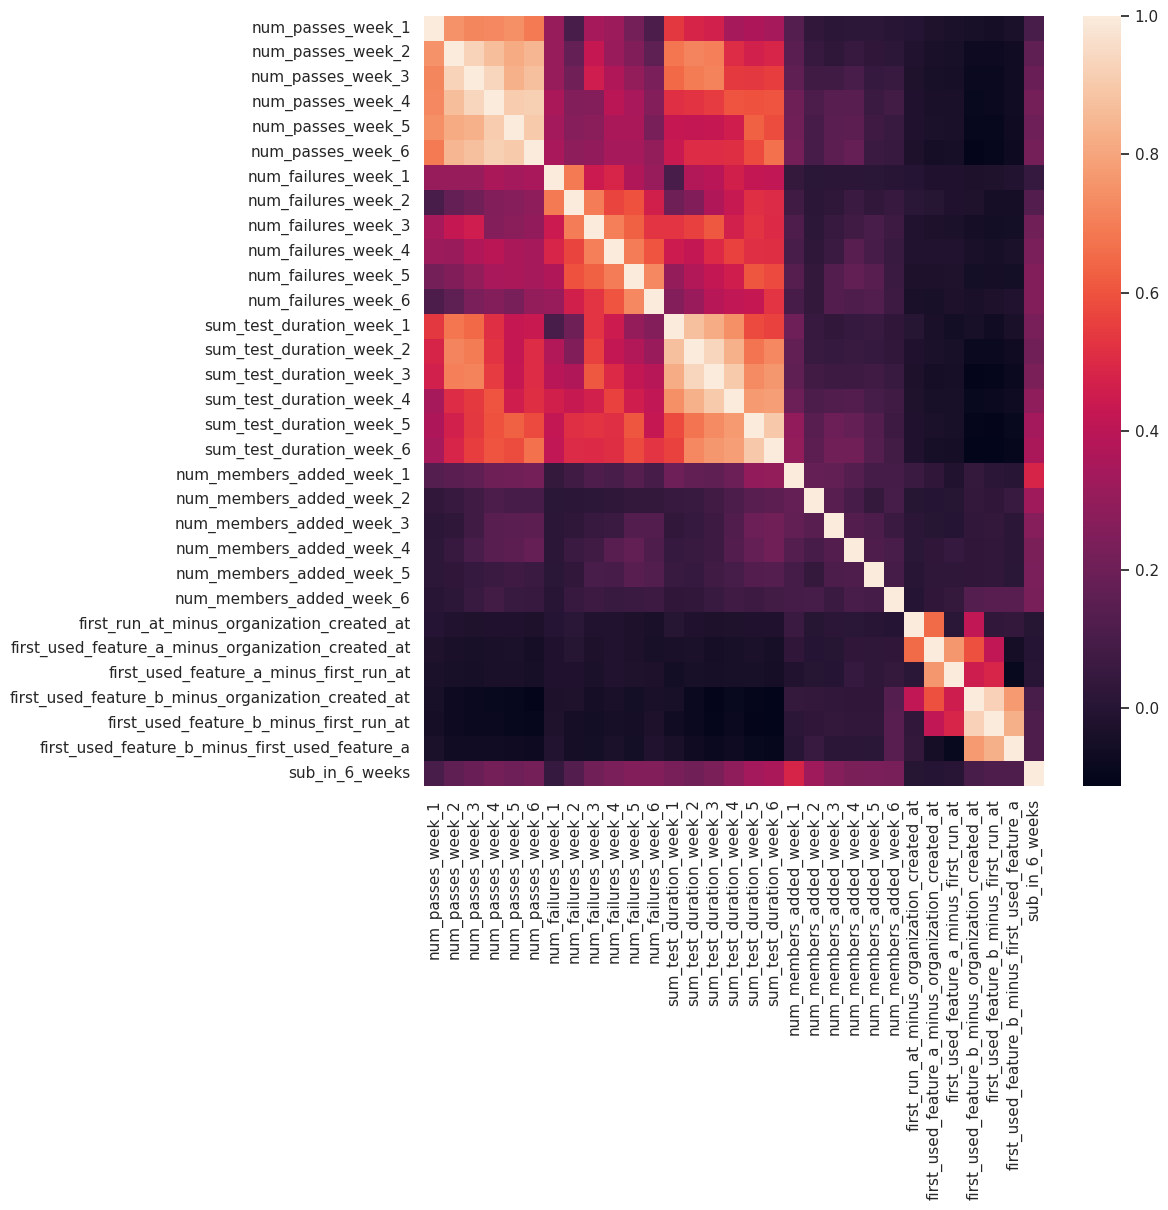

In [20]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(data[list(X.columns) + ['sub_in_6_weeks']].corr())
plt.show()

There are no particularly strong correlations between our target variable, `sub_in_6_weeks`, and the other variables aside from a mild correlation between `sub_in_6_weeks` and `num_members_added_week_1`.

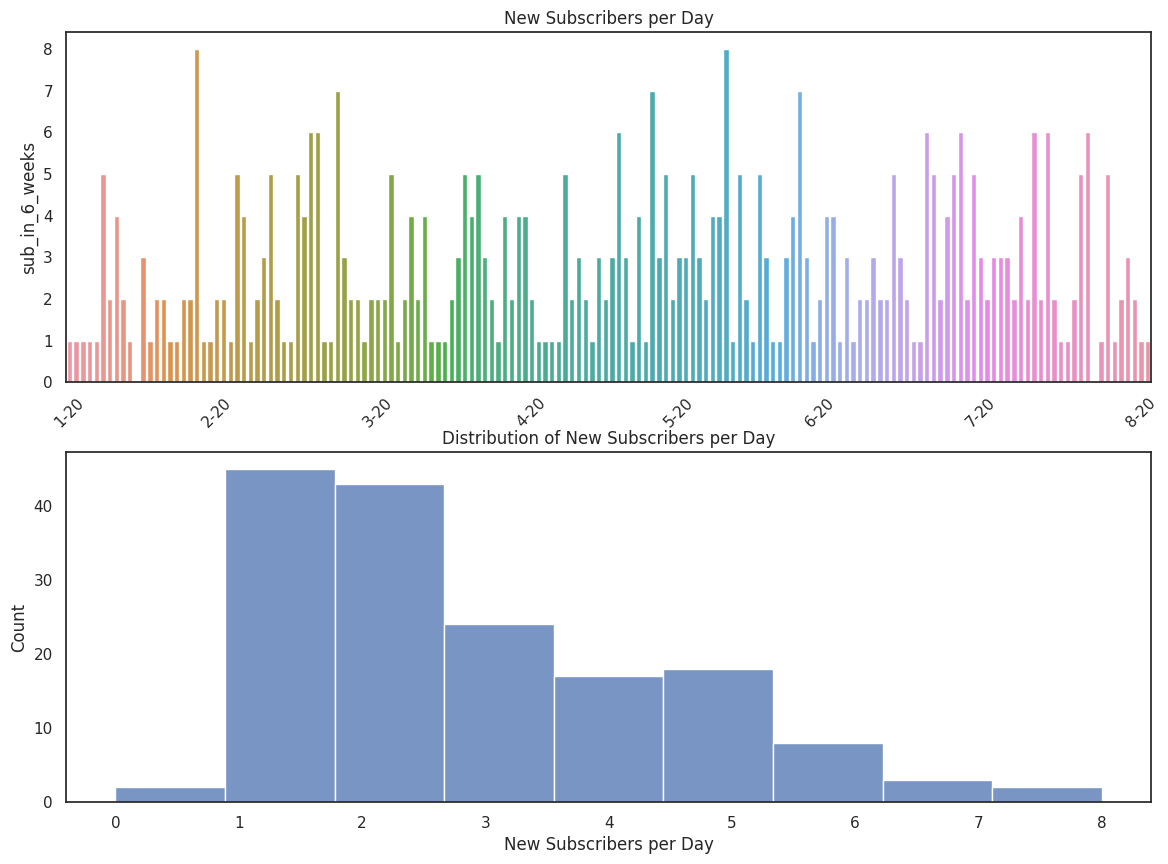

In [21]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(2, figsize=(14,10))

temp = data[
    ['subscription_created_at',
     'sub_in_6_weeks']
].groupby('subscription_created_at').sum().sort_index()

sns.histplot(x=temp['sub_in_6_weeks'], ax=ax[1])

idx = pd.period_range(start=sub_dt_min, end=sub_dt_max, freq='D')
temp.reindex(idx, fill_value=0)

sns.barplot(x=temp.index, y=temp['sub_in_6_weeks'], ax=ax[0], ci=None)

ax[0].set_title('New Subscribers per Day')
ax[1].set_title('Distribution of New Subscribers per Day')
ax[1].set_xlabel('New Subscribers per Day')

date_form = DateFormatter("%m-%y")

labels = []

for dt in temp.index:
    lbl = str(dt.month)+'-'+str(dt.year)[-2:]
    if lbl not in labels:
        labels.append(lbl)
    else:
        labels.append('')

ax[0].xaxis.set_major_formatter(date_form)
ax[0].set_xticklabels(labels, rotation=45)
ax[0].set_xlabel('')

plt.show()

While we could use some time series models, it would not be particularly useful in this case as the granularity is weekly and we are interested in those who subscribe within 6 weeks of starting to use the service. Perhaps, if we had day-level usage for the organizations we could investigate the temporal component more thoroughly. It is satisfying to see the mean number of subscribers per day increase over time, however.

Finally, we split the data into training and testing sets for model development and evaluation.

In [22]:
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, stratify=y, random_state=SEED)

y_train.mean(), y_test.mean()

(0.043417063663923776, 0.043816942551119765)

# Model Experiments

We will compare a wide variety of models to get an idea for which ones we should spend additional time attempting to tune with a search over the hyperparameter space. The process for each experiment is as follows:
1. SMOTE-ENN is used to balance the dataset to roughly 50/50 between both classes
2. The model is instantiated with the specified parameters
3. 5-fold Stratified CV is used to split the training dataset for model training
4. The model is fit and evaluated on test data held-out before resampling
5. The mean score across all 5 folds is saved
6. The process is repeated once for each seed

For this initial set of experiments, we will use the default parameters set in SciKit-Learn. We do this only to get a sense for which models are most likely going to succeed out of the box as this typically corresponds with strong performance after hyperparameter tuning. While personal experience with models is useful to some degree, a more rigorous, scientific approach such as this provides a quantitative basis to inform modeling decisions moving forward.

**Note: The code being used to run these experiments is largely from my prior work and can be found at [my github](https://github.com/DaltonSchutte/PatientNoShowProject/blob/master/3_model_experiments.ipynb). For readability, I've stored all of the functions in the experiments.py file and included it with this report.**

In [23]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

import experiments as exp

sklearn_models = {'SGD': [SGDClassifier],
                  'LogReg': [LogisticRegression], 
                  'GNB': [GaussianNB], 
                  'RF': [RandomForestClassifier], 
                  'Ada': [AdaBoostClassifier],
                  'Bagging': [BaggingClassifier],
                  'SVC': [SVC],
                  'kNN': [KNeighborsClassifier],
                  'Neural': [MLPClassifier]
                 }

Running SGD experiment...



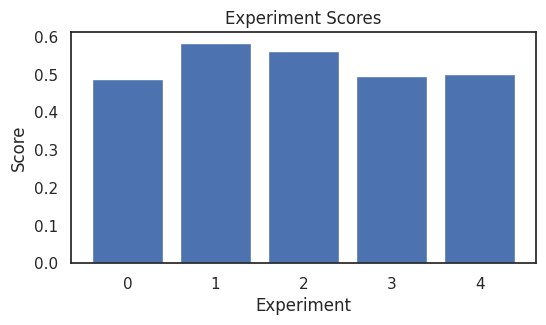

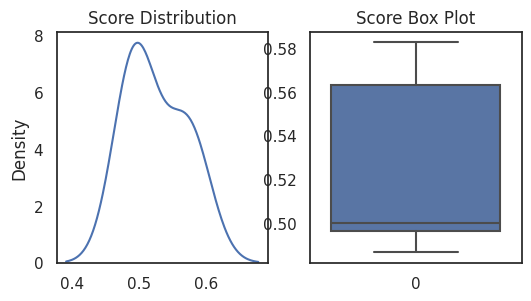

=== Statistics ===
Mean:  0.5258
Median:  0.5
Standard Dev:  0.0392
Range:  (0.4868, 0.5827)
	===	===	===	===	===
Running LogReg experiment...



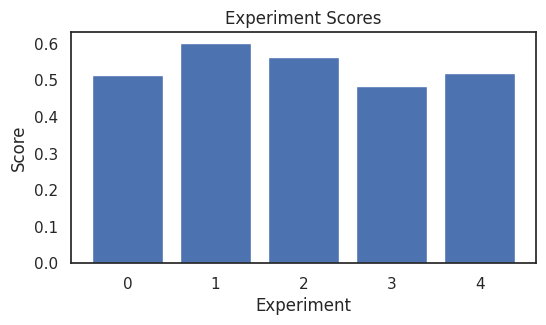

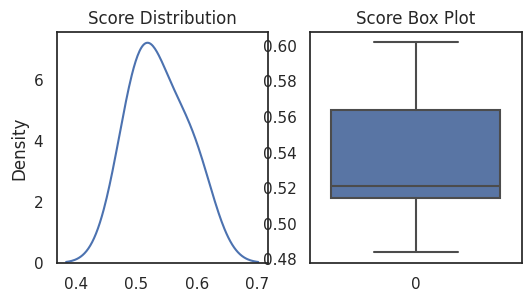

=== Statistics ===
Mean:  0.5367
Median:  0.5211
Standard Dev:  0.0412
Range:  (0.4837, 0.6016)
	===	===	===	===	===
Running GNB experiment...



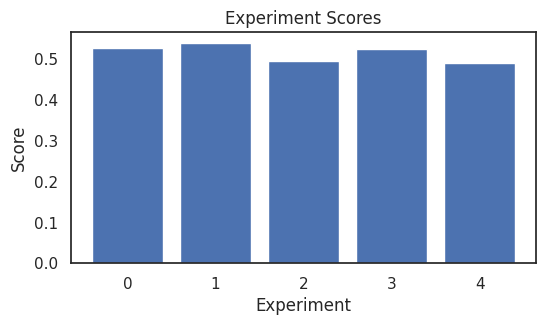

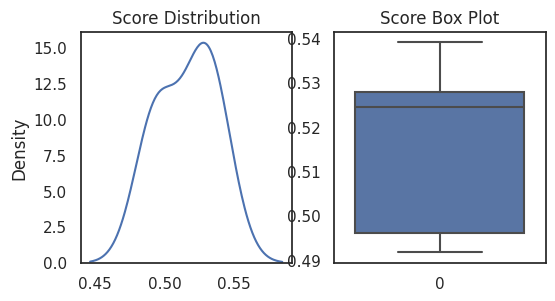

=== Statistics ===
Mean:  0.5159
Median:  0.5246
Standard Dev:  0.0186
Range:  (0.4918, 0.5391)
	===	===	===	===	===
Running RF experiment...



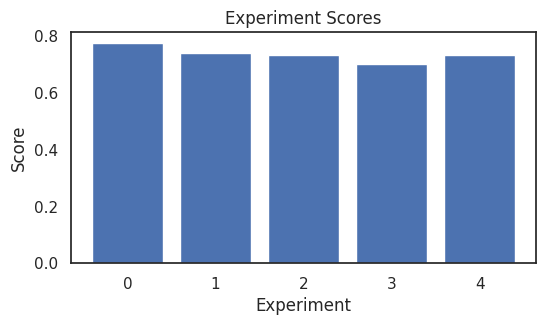

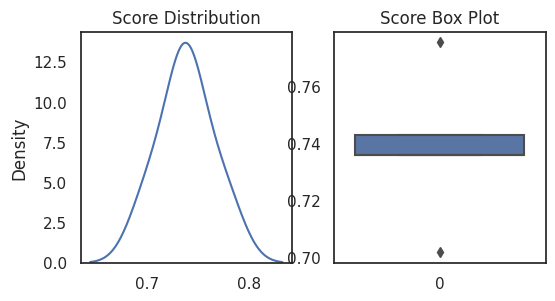

=== Statistics ===
Mean:  0.7384
Median:  0.7358
Standard Dev:  0.0235
Range:  (0.7018, 0.7755)
	===	===	===	===	===
Running Ada experiment...



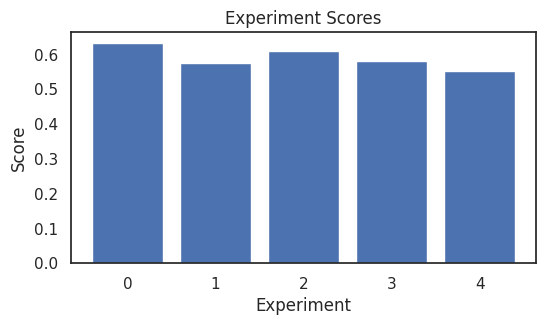

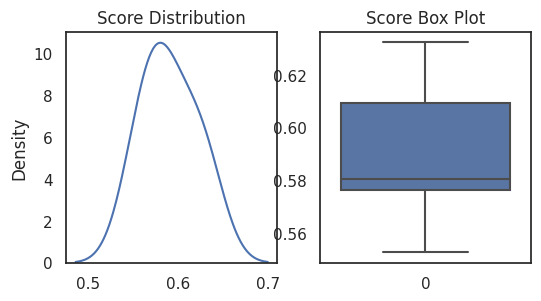

=== Statistics ===
Mean:  0.5904
Median:  0.5806
Standard Dev:  0.0277
Range:  (0.5528, 0.6325)
	===	===	===	===	===
Running Bagging experiment...



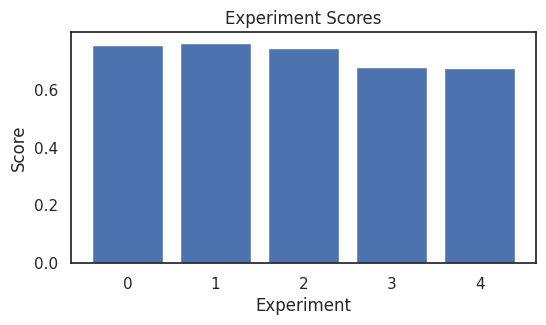

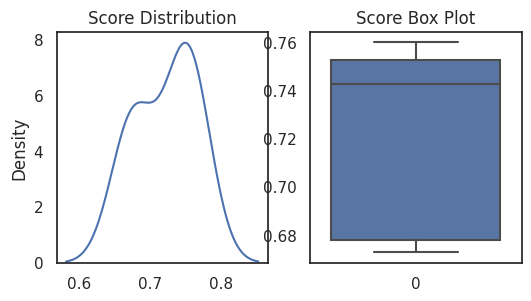

=== Statistics ===
Mean:  0.7212
Median:  0.7429
Standard Dev:  0.0378
Range:  (0.6729, 0.76)
	===	===	===	===	===
Running SVC experiment...



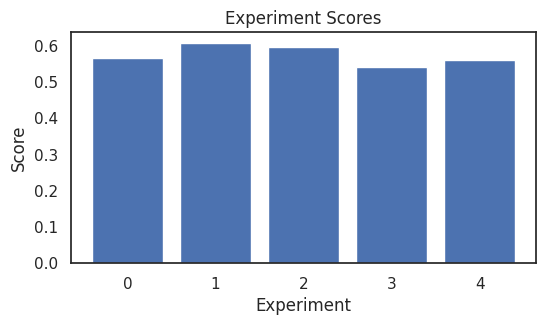

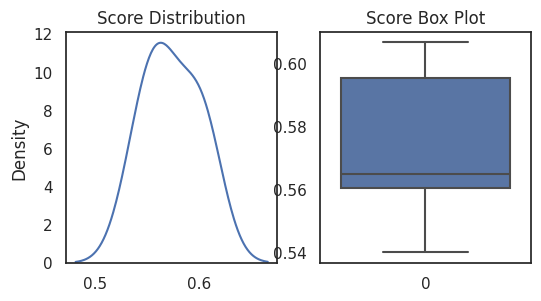

=== Statistics ===
Mean:  0.5735
Median:  0.5649
Standard Dev:  0.0242
Range:  (0.5401, 0.6066)
	===	===	===	===	===
Running kNN experiment...



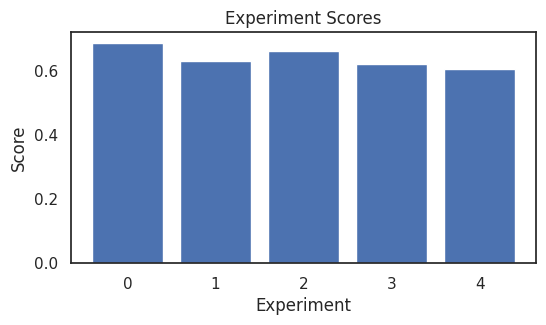

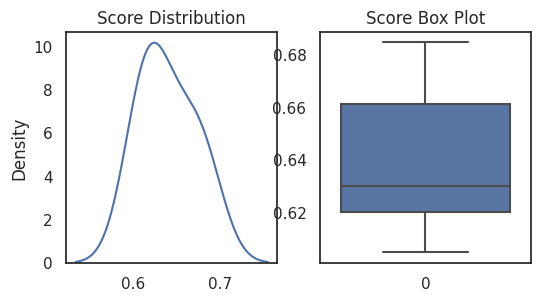

=== Statistics ===
Mean:  0.6401
Median:  0.6299
Standard Dev:  0.0289
Range:  (0.6047, 0.6847)
	===	===	===	===	===
Running Neural experiment...



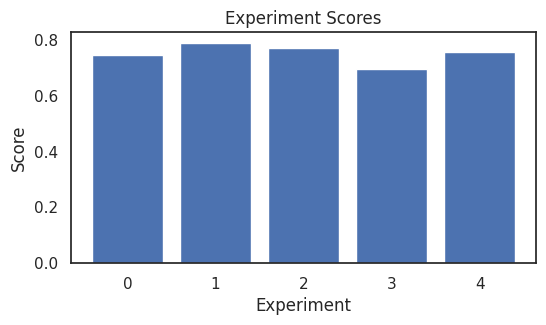

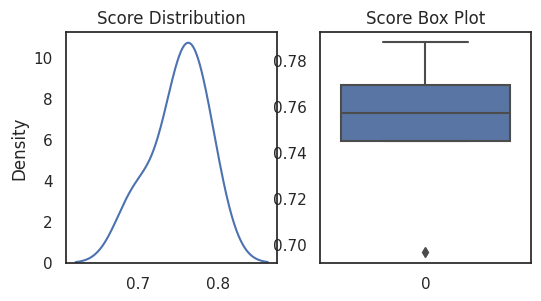

=== Statistics ===
Mean:  0.7512
Median:  0.7573
Standard Dev:  0.0308
Range:  (0.6964, 0.7879)
	===	===	===	===	===


In [24]:
sklearn_results = {}

for name, model in sklearn_models.items():
    print(f"Running {name} experiment...")
    print()
    scores = exp.run_experiments(SEEDS, X_train, y_train, model[0], f1_score, verbose=False)
    sklearn_results.update({name: scores})
    print("\t===\t===\t===\t===\t===")


In [25]:
skl_results_df = pd.DataFrame(sklearn_results.values(), sklearn_results.keys())
skl_results_df['mean'] = skl_results_df.mean(axis=1)

top3_df = skl_results_df.sort_values(by='mean', axis=0, ascending=False).head(3)
top_3 = {k: sklearn_models[k] for k in top3_df.index}
top_3

{'Neural': [sklearn.neural_network._multilayer_perceptron.MLPClassifier],
 'RF': [sklearn.ensemble._forest.RandomForestClassifier],
 'Bagging': [sklearn.ensemble._bagging.BaggingClassifier]}

# Model Development

The top 3 performing models from the above experiments are the random forest, bagging classifier, and neural network. Now we will do a search over hyperparameter spaces by randmoly searching a few parameter combinations over a space for each of the top performing models. Depending on the time and resources available, we would consider a more exhaustive search over the hyperparameter space or consider using Bayesian optimization to find a learned set of hyperparameters for each model.

## Hyperparameter Search

In [26]:
rf_hp_space = {'n_estimators': np.arange(80, 120),
               'criterion': ['gini', 'entropy'],
               'max_depth': np.arange(2, 15),
               'min_samples_split': np.arange(2, 10),
               'min_samples_leaf': np.arange(1, 10),
               'max_features': ['sqrt', 'log2']
              }
bag_hp_space = {'n_estimators': np.arange(5,20),
                'max_samples': np.linspace(0.7,1.0,30),
                'max_features': np.linspace(0.7,1.0,30),
               }
nn_hp_space = {'hidden_layer_sizes': [tuple(np.random.randint(2,150,2)) for _ in range(100)],
               'activation': ['logistic', 'relu', 'tanh'],
               'alpha': np.random.exponential(10, 20),
               'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'learning_rate_init': np.random.exponential(5, 20),
               'max_iter': [250]
               }

spaces = {'RF': rf_hp_space,
          'Bagging': bag_hp_space,
          'Neural': nn_hp_space
         }

In [27]:
from time import time
from sklearn.model_selection import RandomizedSearchCV

best_params = {}

for model_name, space in spaces.items():
    print(f"Optimizing {model_name}...")
    start = time()
    model = top_3[model_name][0]()
    clf = RandomizedSearchCV(model, space, n_iter=50, scoring='f1', 
                             random_state=SEED)
    search = clf.fit(X_train, y_train)
    end = time()
    print(f"Best score: {search.best_score_}\n\t{round(end-start, 2)}")
    best_params[model_name] = search.best_params_

Optimizing RF...
Best score: 0.6718688337066122
	97.93
Optimizing Bagging...
Best score: 0.6976758092414134
	75.98
Optimizing Neural...
Best score: 0.3503396993014364
	898.96


/home/dalton/projects/screeners/maca-dash/env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


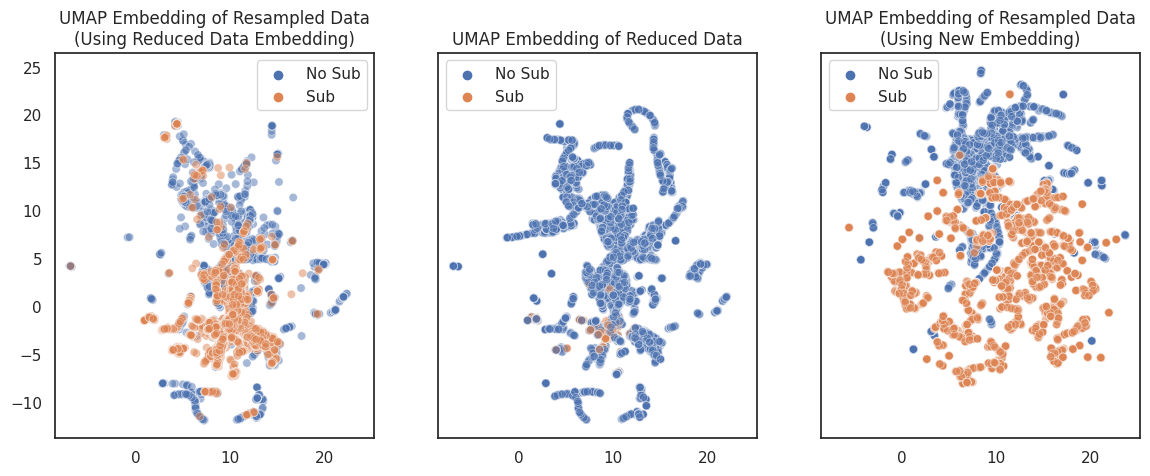

In [28]:
from imblearn.combine import SMOTEENN

resampler = SMOTEENN(random_state=SEED)
X_resample, y_resample = resampler.fit_resample(X_train, y_train)

embedding_resample = reducer_rdx.transform(X_resample)

fig, ax = plt.subplots(1, 3, figsize=(14,5), sharex=True, sharey=True)

sns.scatterplot(x=embedding_resample[:,0], y=embedding_resample[:,1],
                hue=['No Sub' if x == 0 else 'Sub' for x in y_resample],
                ax=ax[0], alpha=0.5
               )
sns.scatterplot(x=embedding_rdx[:,0], y=embedding_rdx[:,1],
                hue=['No Sub' if x == 0 else 'Sub' for x in y],
                ax=ax[1], alpha=0.5
               )

reducer = umap.UMAP(random_state=SEED)
embedding_res_new = reducer.fit_transform(X_resample)

sns.scatterplot(x=embedding_res_new[:,0], y=embedding_res_new[:,1],
                hue=['No Sub' if x == 0 else 'Sub' for x in y_resample],
                ax=ax[2], alpha=0.5
               )

ax[0].set_title('UMAP Embedding of Resampled Data\n(Using Reduced Data Embedding)')
ax[1].set_title('UMAP Embedding of Reduced Data')
ax[2].set_title('UMAP Embedding of Resampled Data\n(Using New Embedding)')
plt.legend()
plt.show()

In looking at the UMAP embeddings of the reduced dataset and the resampled dataset, we see that the global topology of the resampled data is a bit more well separated than the reduced dataset alone. As such, we would expect that the models should produce better results when trained on the resampled dataset. There is a limited amount of information that can be gleaned from 2D representations of higher-dimensional data, so, we should temper our expectations.

## Training

At this point, we will train each of the top models several times using the best parameters that we found using the hyperparameter search and consider the mean metrics across all the runs.

Running RF experiment...

{'n_estimators': 99, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 13, 'criterion': 'gini'}


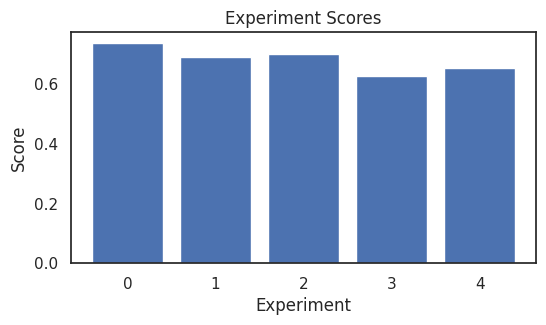

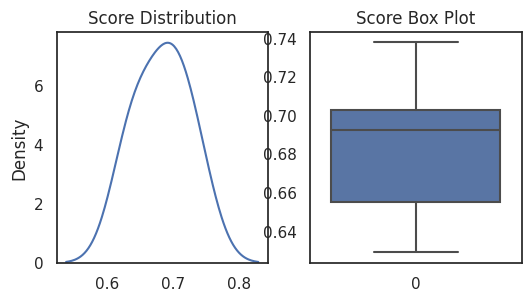

=== Statistics ===
Mean:  0.6834
Median:  0.6923
Standard Dev:  0.0379
Range:  (0.629, 0.7379)
	===	===	===	===	===

Running Bagging experiment...

{'n_estimators': 19, 'max_samples': 0.9275862068965517, 'max_features': 0.896551724137931}


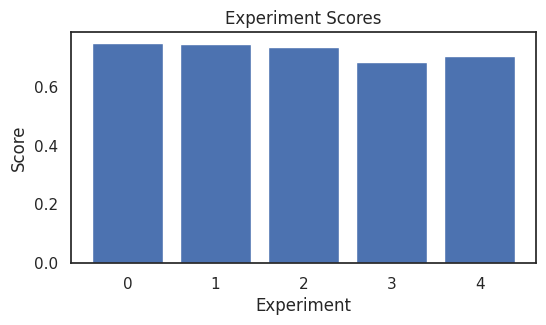

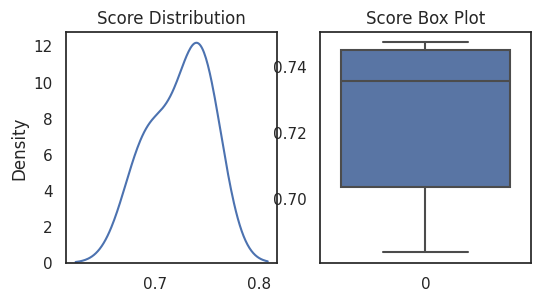

=== Statistics ===
Mean:  0.7232
Median:  0.7358
Standard Dev:  0.0252
Range:  (0.6838, 0.7475)
	===	===	===	===	===

Running Neural experiment...

{'max_iter': 250, 'learning_rate_init': 0.17317819918984848, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (85, 98), 'alpha': 2.218617003718295, 'activation': 'tanh'}


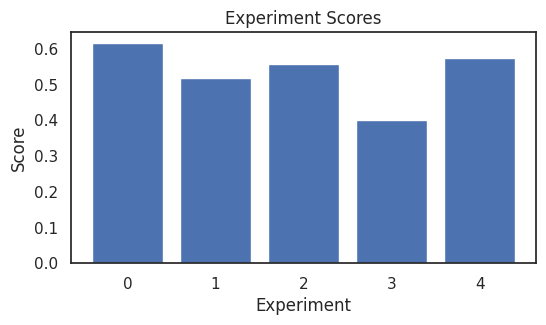

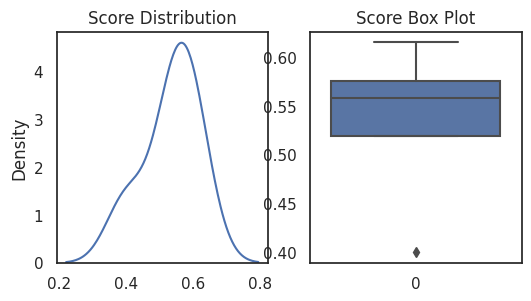

=== Statistics ===
Mean:  0.5336
Median:  0.5581
Standard Dev:  0.0736
Range:  (0.4, 0.6154)
	===	===	===	===	===



In [29]:
top3_results = {}

for name, params in best_params.items():
    model = top_3[name][0]
    print(f"Running {name} experiment...")
    print()
    print(params)
    scores = exp.run_experiments(SEEDS, X_train, y_train, model, f1_score, params, verbose=False)
    top3_results[name] = scores
    print("\t===\t===\t===\t===\t===")
    print()

In [30]:
# Bagging had the best mean and median f1 scores, and so is the model we choose for final evaluation
best_model_params = {'Bagging': best_params['Bagging']}
best_model_params

{'Bagging': {'n_estimators': 19,
  'max_samples': 0.9275862068965517,
  'max_features': 0.896551724137931}}

## Evaluation

Now, we retrain the best model using the best hyperparameter configuration and begin the evaluation process. We will be evaluating the model on both the held-out test set and the cluster that we removed earlier.

In [31]:
best_model = BaggingClassifier(**best_model_params['Bagging'])
best_model.fit(X_train, y_train)

BaggingClassifier(max_features=0.896551724137931,
                  max_samples=0.9275862068965517, n_estimators=19)

### Test Set

In [32]:
from sklearn.metrics import classification_report

best_preds = best_model.predict_proba(X_test)
print(classification_report(y_test, np.argmax(best_preds, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9839    0.9929    0.9883       982
           1     0.8056    0.6444    0.7160        45

    accuracy                         0.9776      1027
   macro avg     0.8947    0.8187    0.8522      1027
weighted avg     0.9760    0.9776    0.9764      1027



And we see that the model performance is not quite as strong as we would hope, but the overall performance is decent with a macro F$_1$ of 0.84. The F$_1$ score for the subscriber class is quite low and we can likely achieve a higher score. So, we will consider the runner-up model now, the Random Forest.

In [33]:
rf_model = RandomForestClassifier(**best_params['RF'])
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict_proba(X_test)
print(classification_report(y_test, np.argmax(rf_preds, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9829    0.9949    0.9889       982
           1     0.8485    0.6222    0.7179        45

    accuracy                         0.9786      1027
   macro avg     0.9157    0.8086    0.8534      1027
weighted avg     0.9770    0.9786    0.9770      1027



We see only a slight improvement over the bagging model. So, we move the Random Forest Classifier to check the performance before beginning to consider some of the other models. We are also likely observing such low scores on the test dataset due to the very limited search of the hyperparameter space that was performed in the interest of time.

In [34]:
nn_model = MLPClassifier(**best_params['Neural'])
nn_model.fit(X_train, y_train)

nn_preds = nn_model.predict_proba(X_test)
print(classification_report(y_test, np.argmax(nn_preds, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9819    0.9949    0.9884       982
           1     0.8438    0.6000    0.7013        45

    accuracy                         0.9776      1027
   macro avg     0.9128    0.7975    0.8448      1027
weighted avg     0.9759    0.9776    0.9758      1027



The performance is worse. Perhaps the most useful thing we can take from this model is that we are seeing the recall for the subscriber class increasing. While we have not received confirmation from the sales team, it would likely be advantageous that as many of the potential subscribers are being brought on as subscribers is the most important objective.

### Dropped Cluster

In [35]:
dropped = data[~data.index.isin(keep_idx)]

X_dropped = dropped[list(sum_stats.index)].drop(columns=['sub_in_6_weeks', 'initial_mrr'])

X_dropped_scaled = scaler.transform(X_dropped.fillna(0))

preds = best_model.predict(X_dropped_scaled)

preds.sum(), preds.mean().round(4)

(71, 0.0046)

In [36]:
preds = rf_model.predict(X_dropped_scaled)

preds.sum(), preds.mean().round(4)

(59, 0.0038)

In [37]:
preds = nn_model.predict(X_dropped_scaled)

preds.sum(), preds.mean().round(4)

(45, 0.0029)

# Discussion

## Model Performance

The final Random Forest model trained with the best parameter configuration, obtained a macro average F1 score of 0.8430 for determining if an organization would eventually become a subscriber or not. This is decent performance relative to the risk associated with the task. Further experimentation and tuning of the model would allow the sales team to perform even more accurate targeted outreach. However, if this is an improvement over the current approach, it would be a worthwhile model to deploy while further tuning is done and additional data is collected. Additional data will also allow us to determine if there is a statistically significant increase in the efficacy of the sales team's efforts after the model has been deployed.

The model obtained fine recall for predicting which organizations would become subscribers within 6 weeks of first using the product, but did better with precision. This is, overall, not ideal. The low recall means that the sales team is more likely to miss engaging with a potential subscriber than they are wasting their time with an organization less likely to subscribe. However, if the current approach has required the sales team reach out to all organizations, the precision of 0.76 for the Random Forest model is a considerable improvement over the current blanket approach.

The most utility from the model can be obtained by placing a lower priority on the organizations that are predicted to not subscribe, as the precision and recall for the class of non-subscribers is very high. The sales team can be fairly confident if the model classifies an organization as a non-subscriber, then they can safely de-prioritize engaging with them and not risk losing a potential new subscriber.

The trained model mislabeled the fewest number of observations in the dropped cluster as subscribers. This is useful knowledge, since it suggests that the dropped cluster is fairly disjoint from the rest of the data in the full feature space. This cluster should be studied as it might have additional information about a large subset of the userbase. A better understanding of this subset could be leveraged in the future to try and convert more organizations into paying subscribers.

## Calibration Curve

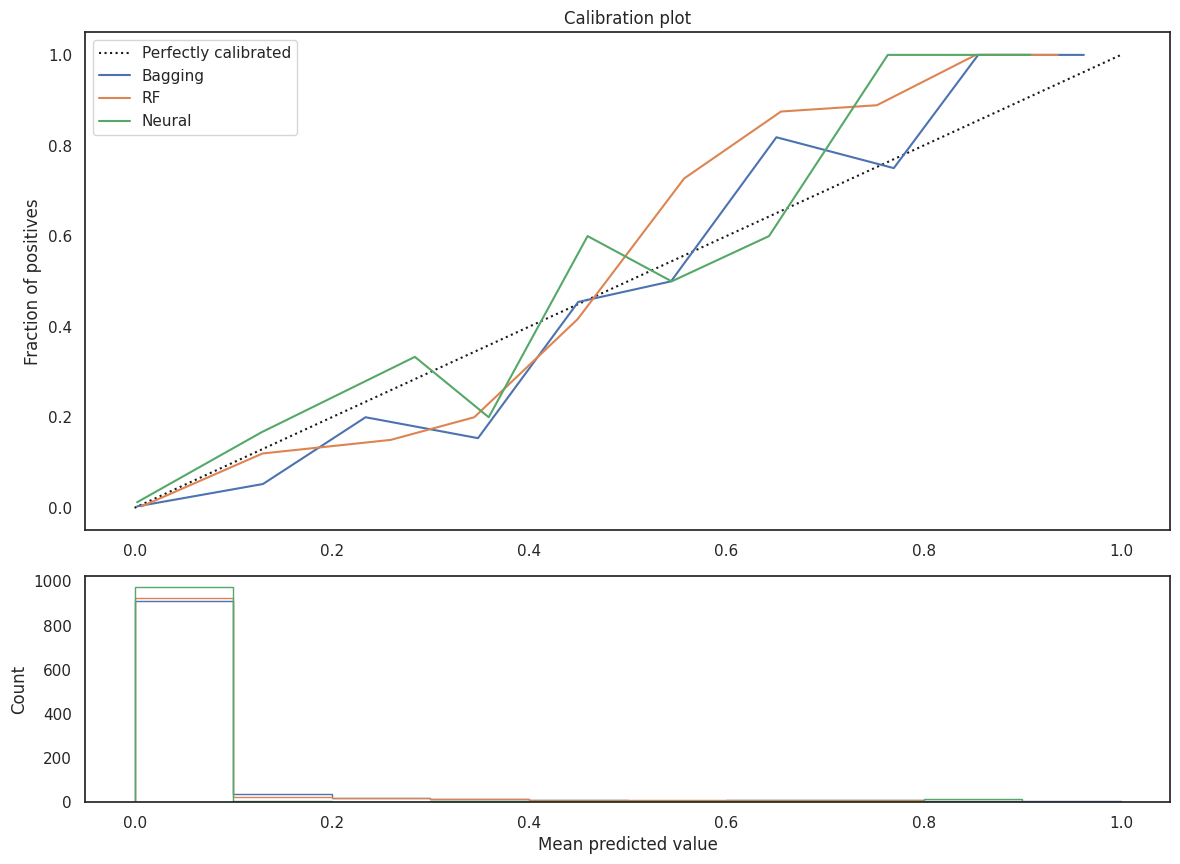

In [38]:
from sklearn.calibration import calibration_curve

fig = plt.figure()
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for model, m_preds in zip(['Bagging','RF','Neural'], [best_preds, rf_preds, nn_preds]):
    p_true, p_pred = calibration_curve(y_test, m_preds[:,1], n_bins=10)

    ax1.plot(p_pred, p_true, label=model)
    ax2.hist(m_preds[:,1], range=(0,1), bins=10, histtype='step')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper left")
ax1.set_title('Calibration plot')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")

plt.show()

Overall, these models are fairly well calibrated. However, in the context of being used by the sales team, this is perhaps acceptable. We see, from the histogram, that the neural net tends to assign the subscriber class more often than the other two models. However, it is not well calibrated in the sense that, from this particular model, it is overestimating the risks. In other words, it is more-likely to return a False Positive (the sales team wasting time) than it is a False Negative (the sales team missing a potential new subscriber). In the context of trying to bring in new subscriber, this would be advantageous since in pursuing an organization that is not predicted to become a subscriber there is some chance that a new subscriber is brought on. However, that chance is severely diminished, or even non-existent, if no attempt is made by the sales team with that organization.
<br><br>
The other two models show fairly good calibration. With the random forest model tending to struggle a bit more with discriminating between the classes and tends to underestimate the likelihood an organization will become a subscriber when it is in the realm of 50-60% for its prediction likelihood.

## Variable Dependence

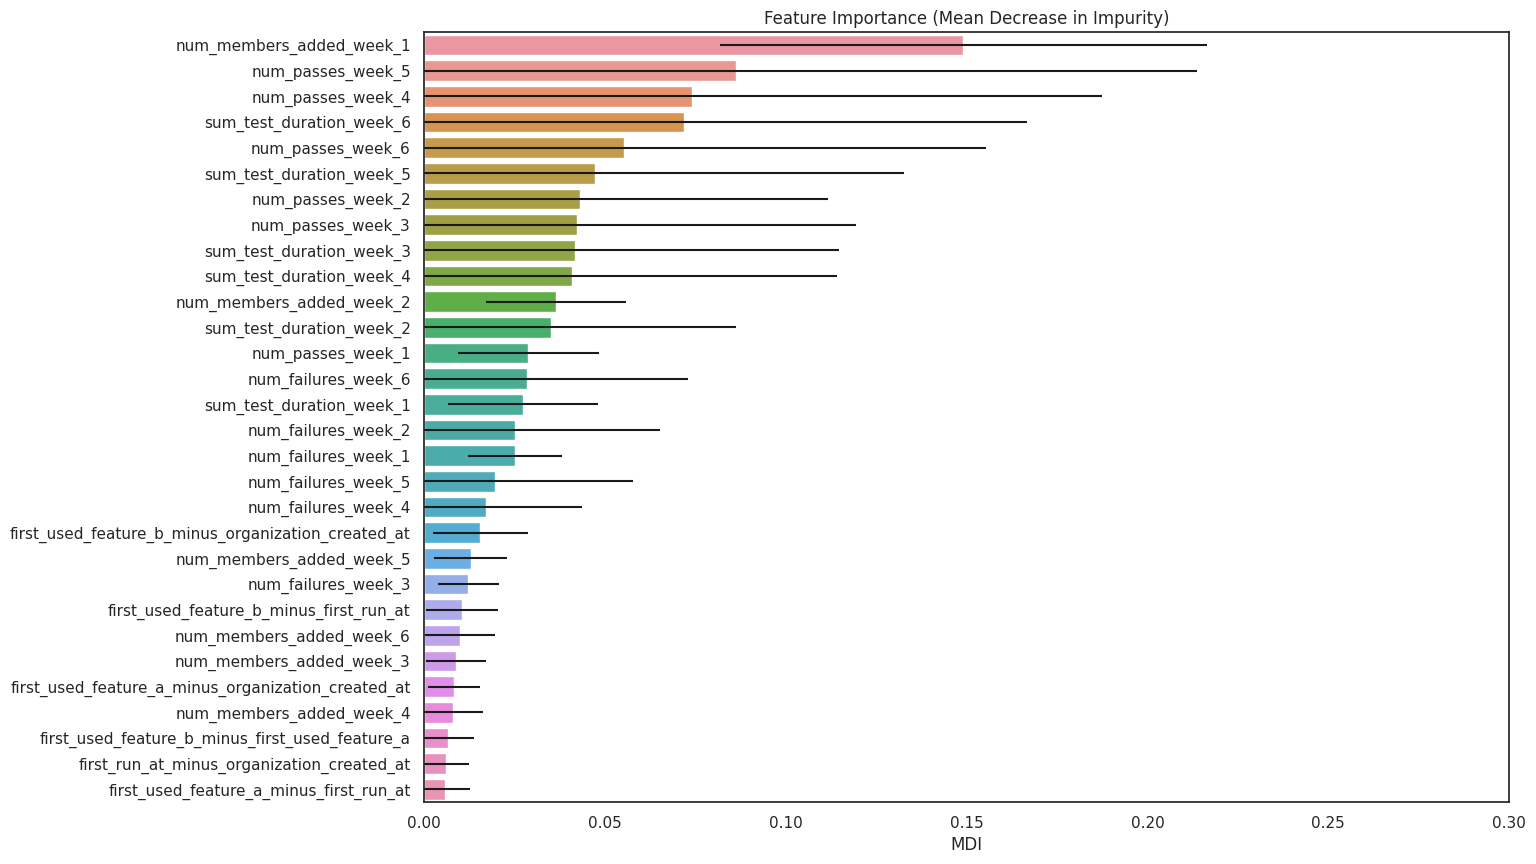

In [39]:
warnings.simplefilter("ignore", UserWarning)

importances = rf_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

rf_importances = pd.DataFrame(importances, index=X.columns).reset_index().sort_values(0, ascending=False)
std = std[rf_importances.index]

fig, ax = plt.subplots()
sns.barplot(x=rf_importances[0], y=rf_importances['index'], xerr=std, ax=ax)
ax.set_yticklabels(rf_importances['index'])
ax.set_ylabel('')
ax.set_title("Feature Importance (Mean Decrease in Impurity)")
ax.set_xlabel("MDI")
ax.set_xlim(0,0.3)
plt.show()

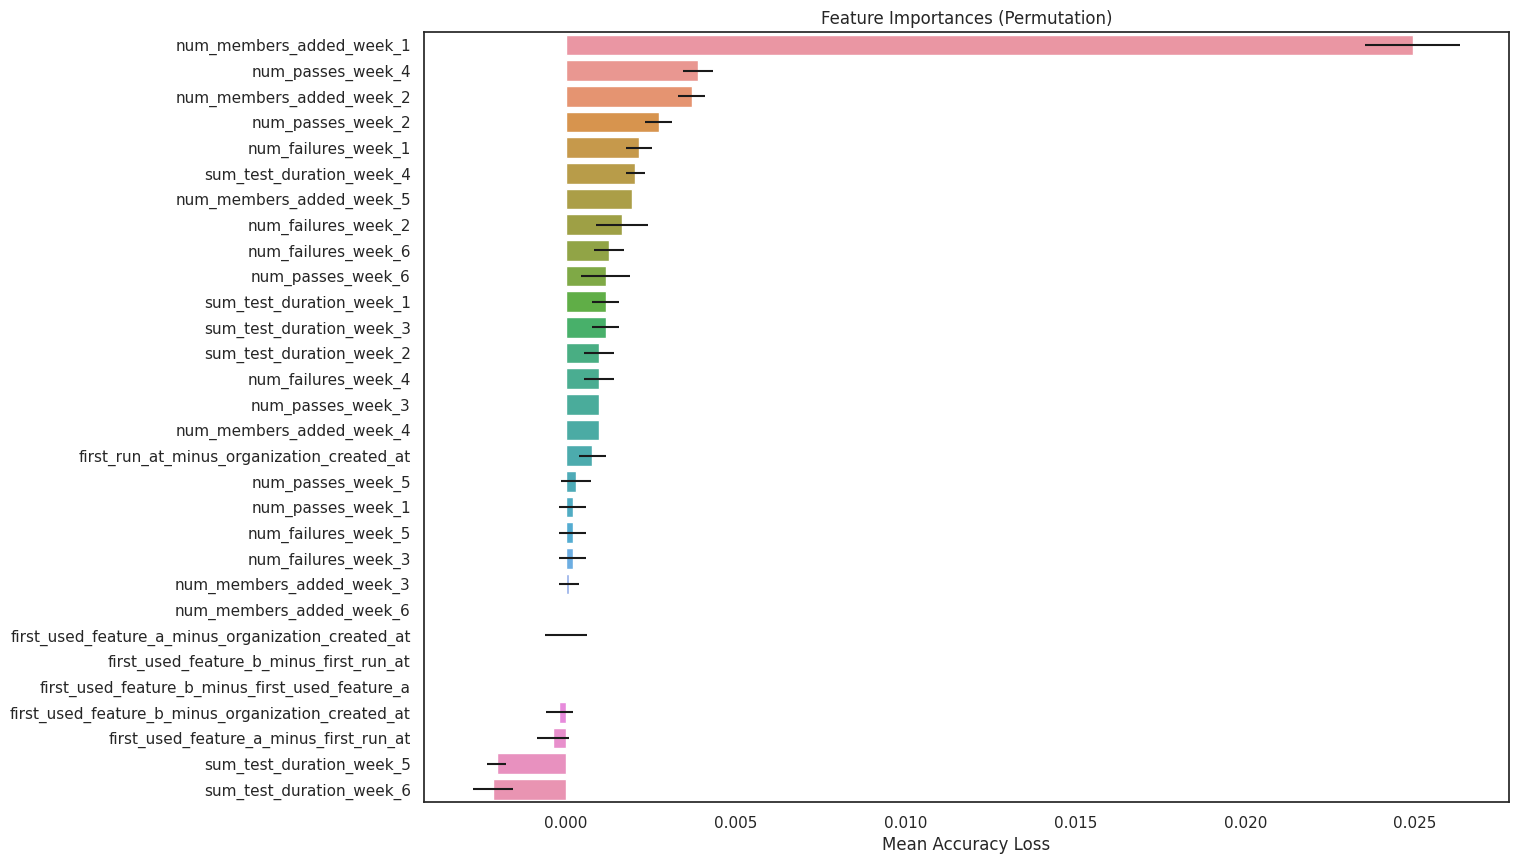

                       index         0  mag_loss
18  num_members_added_week_1  0.024927  0.024927
3          num_passes_week_4  0.003895  0.003895
19  num_members_added_week_2  0.003700  0.003700
1          num_passes_week_2  0.002726  0.002726
6        num_failures_week_1  0.002142  0.002142


In [40]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=SEED)

rf_importances = pd.DataFrame(importances.importances_mean, index=X.columns).reset_index().sort_values(0, ascending=False)
std = importances.importances_std[rf_importances.index]

fig, ax = plt.subplots()
sns.barplot(x=rf_importances[0], y=rf_importances['index'],  xerr=std, ax=ax)
ax.set_yticklabels(rf_importances['index'])
ax.set_ylabel('')
ax.set_title("Feature Importances (Permutation)")
ax.set_xlabel("Mean Accuracy Loss")
plt.show()

rf_importances['mag_loss'] = rf_importances[0].abs()

print(rf_importances.sort_values('mag_loss', ascending=False).iloc[:5])

In [41]:
import joblib

joblib.dump(rf_model, '../weights/churn/model.joblib')

['../weights/churn/model.joblib']

The Mean Decrease in Impurity measure of feature importance is known to be biased towards continuous variables so we also used permutation importance to determine the relative importance of the features. Permutation importance is known to be biased when there are strong correlations between the dependent variable and any of the independent variables. However, we did not observe any strong correlations. The strongest being between the `num_members_added_week_1` and the dependent variable also happened to be the top ranked feature for our random forest model. So, we will focus on the results from the permutation technique.

In total, 19 of the variables had statistically significant effects on the accuracy loss of our model. The five statistically significant features with the most impact on the accuracy of our model are shown above. It seems that the strongest indicators for if an organization will subscribe are the number of members the organization adds in the first two weeks and in the fifth week after running their first test. Also, the number of tests passed in weeks 2 and 6 are modest contributors.

This suggests that the larger the organization when it first uses the tool, the more likely they might be to subscribe than a smaller organization. Since the tool deals with automation of testing processes, it makes sense that a larger organization might have more to benefit if more of its resources can be allocated to other important, non-automated tasks. The relative importance of the number of tests passed is also somewhat expected. The more tests that can be successfully passed using an automated process would be an enticing prospect and so seeing a larger volume of tests being passed would encourage an organization to subscribe and further receive the benefits of the automated testing.


## Future Directions
There are two main objectives we would like to pursue in the future. The first being analysis of the dropped cluster and the second being incorporation of temporal information into the models.

We discussed the potential benefits of analyzing the dropped class above, but will briefly restate that there is likely some collection of features that can be used to help understand nearly 60% of the user base. A deeper understanding of the customer segments is rarely a bad asset to have.

The data includes weekly data for each organization. It would be interesting to consider a model that produces likelihood scores, or, likely more useful, learned representations, as the weeks progress and the likelihood scores are fed to a simple time series analysis model to project when the sales team might want to engage with an organization to maximize the likelihood of landing a new subscriber. Similarly, the learned representations can be fed to another, more complex, model that can produce projections for when the ideal time to engage might be.

Additionally, more resources and time to conduct more exhaustive model development would be another worthwhile step after this one has been deployed. It would also be worthwhile to investigate training a model that is specifically trained on the organizations the random forest model predicts will be subscribers since the precision is low and there is room for refinement.


# Conclusion

In the course of our analysis and modeling efforts, we obtained two key results. 

We trained a model that obtained a macro average F$_1$ score of 0.84 and weighted average of 0.97. Both of which are solid results for an initial model to deploy to production to assist the sales team in identifying which organizations are not likely to become subscribers within the next 6 weeks. Our final recommendation with regards to the model, is that the sales team can safely de-prioritize reaching out to customers the model predicts are not going to subscribe within the next 6 weeks, unless their personal expertise suggests otherwise.

We also identified a cluster of users that are tightly grouped locally but separated globally from the rest of the userbase. This newly discovered cluster might contain information that will prove useful for future modeling or sales efforts.